## Lab 1

1. Найти лицо на изображении.
2. Отступить на 10% от границ лица и получить этот фрагмент изображения. Далее работа только с этим фрагментом.
3. Получить изображение краев (границ объектов). Например, методом Canny.
4. Удалить мелкие границы у которых длина и ширина меньше 10.
5. Найти угловые точки на исходном изображении и добавить их в изображение границ.
6. Применить морфологическую операцию наращивания (размер структурирующего элемента 5 x 5).
7. Сгладить полученное изображение краев гауссовским фильтром 5 на 5. 
8. Получить нормализованное изображение M, где все пикселы принимают значение от 0 до 1. 
9. Сгладить изображение лица произвольным фильтром (получаем на выходе изображение F1).
10. Получить изображение F2 лица с улучшенной четкостью/контрастностью (любым методом).
11. Осуществить финальную фильтрацию по формуле:
Result[x,y,c] = M[x,y]*F2[x,y,c]+(1-M[x,y])*F1[x,y,c]
где x=1..width, y=1..height, c = 1..3.  

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Загрузим исходное изображение

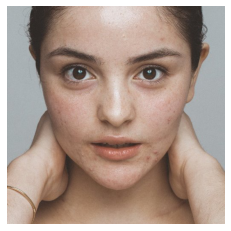

In [2]:
img = cv2.imread('D:\Data/photo2.png')
def show_bgr(image):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
show_bgr(img)

### 1. Найти лицо на изображении.
Распознавать на изображении лицо будем с помощью алгоритма “haarcascade”

In [3]:
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
find_face =  haar_cascade.detectMultiScale(img, minNeighbors=4, minSize=(30, 30))   

### 2. Отступить на 10% от границ лица и получить этот фрагмент изображения.

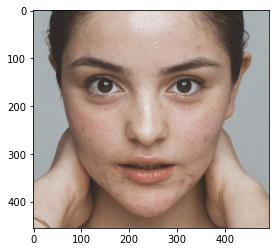

In [4]:
faces = []

for (x, y, width, height) in find_face:
    faces.append(img[int(np.clip(y - height * 0.1, 0, img.shape[0])): int(np.clip(y + height * 1.1, 0, img.shape[0])),
                     int(np.clip(x - width * 0.1, 0, img.shape[1])): int(np.clip(x + 1.1 * width * 1.1, 0, img.shape[1]))].copy())
    
img = cv2.cvtColor(faces[0], cv2.COLOR_BGR2RGB)

plt.imshow(img)

### 3. Получить изображение краев (границ объектов). Метод Canny.

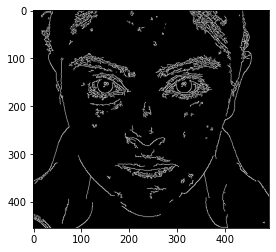

In [5]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # сделаем изобрважение серым, чтобы было меньше шума
canny_image = cv2.Canny(gray_img, 60, 150)
canny_image1 = cv2.cvtColor(canny_image, cv2.COLOR_BGR2RGB)
plt.imshow(canny_image1)

### 4. Удалить мелкие границы у которых длина и ширина меньше 10.

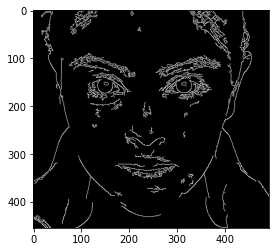

In [6]:
lines, _ = cv2.findContours(canny_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
face_contours = []
for n in lines:
    _, _, length_l, width_l, = cv2.boundingRect(n)
    if length_l >= 10 or width_l >= 10:
        face_contours.append(n)
    
return_image = np.zeros_like(img)
line_img = cv2.drawContours(return_image, face_contours, -1, (255, 255, 255))
plt.imshow(line_img)

### 5. Найти угловые точки на исходном изображении и добавить их в изображение границ.

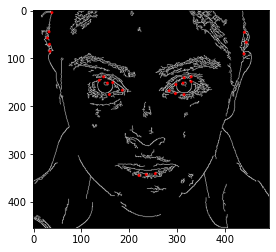

In [7]:
corners = cv2.goodFeaturesToTrack(gray_img, 25, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    img_corn = cv2.circle(line_img,(x,y), 3, 255, -1)

plt.imshow(img_corn)

### 6.Применить морфологическую операцию наращивания (размер структурирующего элемента 5 x 5).

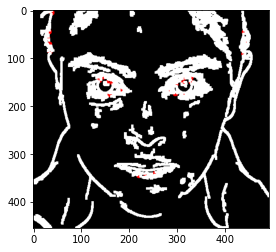

In [8]:
kernel = np.ones((5, 5), 'uint8')
dilated = cv2.dilate(line_img, kernel)
plt.imshow(dilated)

### 7. Сгладить полученное изображение краев гауссовским фильтром 5 на 5.

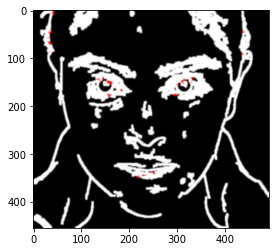

In [9]:
blur_img = cv2.GaussianBlur(dilated, (5, 5),0,0)
plt.imshow(blur_img)

### 8. Получить нормализованное изображение M, где все пикселы принимают значение от 0 до 1.

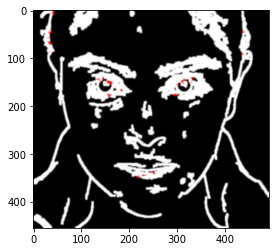

In [10]:
M = cv2.normalize(blur_img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(M)

### 9. Сгладить изображение лица произвольным фильтром (получаем на выходе изображение F1).

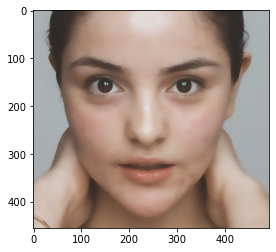

In [11]:
F1 = cv2.bilateralFilter(img, 15, 75, 75)
plt.imshow(F1)

### 10. Получить изображение F2 лица с улучшенной четкостью/контрастностью (любым методом).

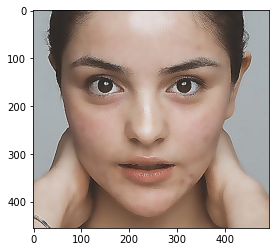

In [12]:
sharp_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
F2 = cv2.filter2D(F1, ddepth=-1, kernel=sharp_filter)
plt.imshow(F2)

### 11. Осуществить финальную фильтрацию по формуле:
Result[x,y,c] = M[x,y]*F2[x,y,c]+(1-M[x,y])*F1[x,y,c],  
где x=1..width, y=1..height, c = 1..3.  

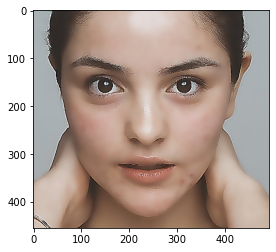

In [13]:
result_img = np.clip(M * F2 + (1 - M) * F1, 0, 255).astype(np.uint8)
plt.imshow(result_img)

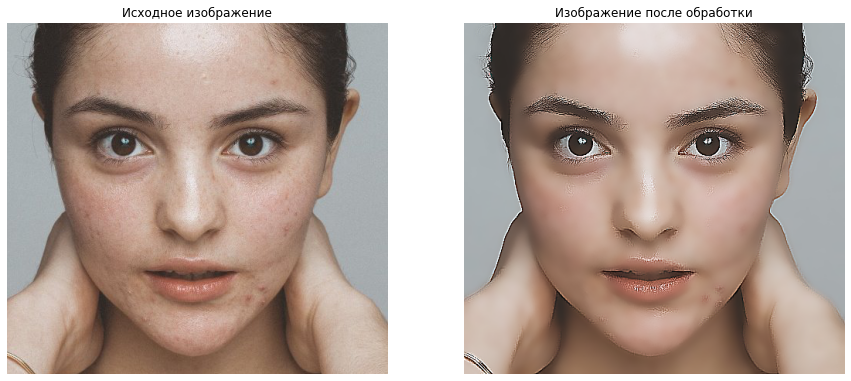

In [14]:
def show_result(img):
    f, ax = plt.subplots(1, 2)
    f.set_figheight(15)
    f.set_figwidth(15)

    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title("Исходное изображение")

    ax[1].imshow(result_img)
    ax[1].axis('off')
    ax[1].set_title("Изображение после обработки")
    pass

show_result(img)